# Gaussian Mixture Model (Dummy dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# data filenames
data_filename   = './dummy_data_d.csv'
trace_filename  = './traces/trace_dummy'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data

1: blue


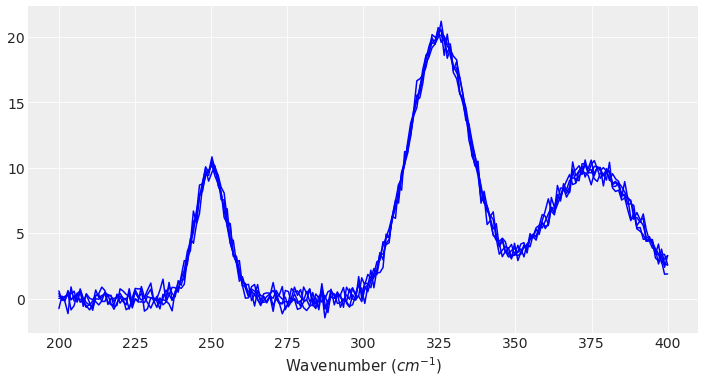

In [5]:
# plot dataframe
utl.plot_data(data_obj, 5)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

1    30
Name: label, dtype: int64


# Model definition (Gaussian Mixture)

In [7]:
x_n = data.columns[:data_obj.non_data_columns]
x_s = data[x_n].values
x_val = np.array(data.columns[:data_obj.non_data_columns], dtype='float32')

In [10]:
import theano.tensor as tt

peaks = [2, 3, 4, 5]
traces = []
models = []

for npeaks in peaks:
    print("training on " + str(npeaks) + " peaks")
    with pm.Model() as model:
        amp = pm.Uniform('amp', 0, x_s.max(), shape=(1,npeaks))
        #sigma_m = pm.Gamma('sigma_m', alpha=10., beta=.25)
        mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), 
                       sd=50, shape=(1,npeaks), transform=pm.distributions.transforms.ordered)
        #sigma_s = pm.Gamma('sigma_s', alpha=10., beta=.25)
        sigma = pm.HalfNormal('sigma', sd=100, shape=(1,npeaks))
        epsilon = pm.HalfNormal('epsilon', sd=1)

        y = pm.Deterministic('y', (amp.T * np.exp(-(x_val - mu.T)**2/(2 * sigma.T**2))).sum(axis=0))
        
        y_pred = pm.Normal('y_pred', mu=y, sd=epsilon, observed=x_s)

        trace = pm.sample(2000, init='adapt_diag', random_seed=42)
        traces.append(trace)
        models.append(model)

training on 2 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:19<00:00, 254.53draws/s]
The acceptance probability does not match the target. It is 0.9372920199208924, but should be close to 0.8. Try to increase the number of tuning steps.


training on 3 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [04:19<00:00, 19.30draws/s]
The acceptance probability does not match the target. It is 0.9950629336881648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.996664801970848, but should be close to 0.8. Try to increase the number of tuning steps.


training on 4 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [04:50<00:00, 17.23draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9977145898274807, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.998032456113822, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


training on 5 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [10:17<00:00,  8.10draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9919957208554636, but should be close to 0.8. Try to increase the number of tuning steps.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9763869006705475, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


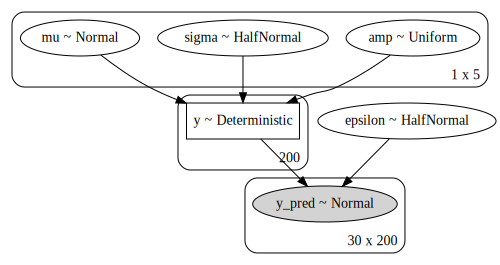

In [11]:
pm.model_to_graphviz(model)

# Model evaluation

In [12]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon']
#coef = az.summary(trace, varnames)
#coef

In [13]:
#az.plot_trace(trace_mgp, varnames);

In [14]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(peaks))]

100%|██████████| 500/500 [00:01<00:00, 317.44it/s]


In [15]:
#data_ppc = az.from_pymc3(trace=trace, posterior_predictive=ppc)
#ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

In [16]:
comp = az.compare(dict(zip(peaks, traces)), method='BB-pseudo-BMA')
comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
3,0,8751.09,10.0406,0,0.360959,112.839,0,False,deviance
4,1,8751.12,10.0018,0.0288246,0.354536,112.804,0.26662,False,deviance
5,2,8751.58,10.1474,0.490064,0.284505,130.937,0.514892,False,deviance
2,3,32635.7,6.80411,23884.6,0,112.859,169.958,False,deviance


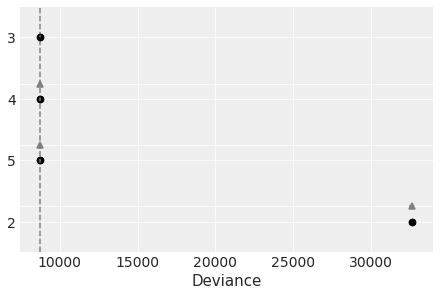

In [17]:
az.plot_compare(comp);

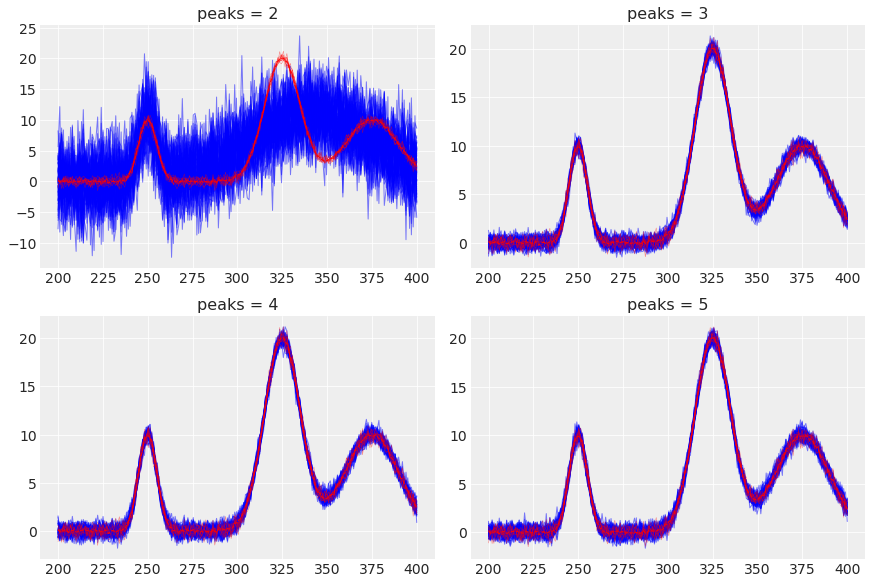

In [18]:
_, ax = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
 
ax = np.ravel(ax)

for idx, ppc_x in enumerate(ppc_mm):
    # plot samples from the posterior
    sp = ppc_x['y_pred']
    for i in range(50):
        ax[idx].plot(x_val, sp[i,0,:], '-', color="blue", linewidth=1, alpha=.5)
    
    # plot samples from the dataset
    for i in range(10):
        y_val = data.values[i]
        ax[idx].plot(x_val, y_val[:data_obj.non_data_columns], '-', color="red", alpha=.5, linewidth=.5)
        
    # plot the mean of the real data
    ax[idx].plot(x_val, data_obj.data.iloc[:,:data_obj.non_data_columns].mean(), '--', color='red', linewidth=1);
    ax[idx].set_title('peaks = {}'.format(peaks[idx]))

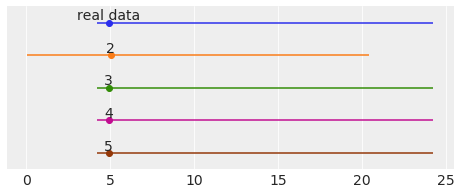

In [20]:
plt.figure(figsize=(8, 3))
data = [x_s]
dd = [ppc_mm[i]['y_pred'] for i in range(len(ppc_mm))]
data.extend(dd)
labels = ['real data']
pk = [str(peaks[i]) for i in range(len(peaks))]
labels.extend(pk)
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [2.5, 97.5])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.1, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

In [21]:
for idx, trace in enumerate(traces):
    print(str(peaks[idx]) + " peaks, bfmi: " + str(az.bfmi(trace)))

2 peaks, bfmi: [1.03533669 1.10194573]
3 peaks, bfmi: [1.02862154 0.98792092]
4 peaks, bfmi: [0.91764637 0.92537906]
5 peaks, bfmi: [0.85869849 0.79882059]


In [22]:
for idx, ppc in enumerate(ppc_mm):
    print("--- " + str(peaks[idx]) + " peaks -----------\n" + str(az.r2_score(x_s, ppc['y_pred'])))

--- 2 peaks -----------
r2        0.533809
r2_std    0.015807
dtype: float64
--- 3 peaks -----------
r2        0.991591
r2_std    0.000526
dtype: float64
--- 4 peaks -----------
r2        0.991597
r2_std    0.000531
dtype: float64
--- 5 peaks -----------
r2        0.991607
r2_std    0.000523
dtype: float64


In [23]:
varnames = ['amp', 'mu', 'sigma', 'epsilon']
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    coef = az.summary(trace, varnames)
    print(coef)


--- 2 peaks ----------------------------------
               mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
amp[0,0]      9.888  0.281    9.336   10.386      0.005    0.003    3560.0   
amp[0,1]     11.187  0.111   10.988   11.400      0.002    0.001    3778.0   
mu[0,0]     249.854  0.163  249.544  250.153      0.002    0.002    4261.0   
mu[0,1]     340.866  0.455  340.018  341.700      0.007    0.005    4085.0   
sigma[0,0]    4.808  0.152    4.534    5.101      0.003    0.002    3403.0   
sigma[0,1]   32.952  0.423   32.216   33.812      0.007    0.005    3329.0   
epsilon       3.666  0.033    3.604    3.728      0.001    0.000    4078.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
amp[0,0]    3560.0    3561.0    3101.0    1.0  
amp[0,1]    3778.0    3795.0    3053.0    1.0  
mu[0,0]     4261.0    4266.0    3155.0    1.0  
mu[0,1]     4084.0    4106.0    2947.0    1.0  
sigma[0,0]  3403.0    3407.0    2831.0    1.0  
sigma[0,1]  3328.0    3345.0    2891.0 